In [ ]:
!pip install -q torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os


In [ ]:
# Cat = 3, Dog = 5 in CIFAR-10
class FilteredCIFAR10(datasets.CIFAR10):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data, self.targets = self._filter_data()

    def _filter_data(self):
        data, targets = [], []
        for img, label in zip(self.data, self.targets):
            if label in [3, 5]:  # Only cat or dog
                data.append(img)
                targets.append(0 if label == 3 else 1)  # 0: cat, 1: dog
        return data, targets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

train_data = FilteredCIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = FilteredCIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)



100%|██████████| 170M/170M [01:17<00:00, 2.20MB/s]


In [ ]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatDogCNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_accuracies = [], []

for epoch in range(5):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Eval
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).int().squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Test Acc: {acc:.2f}")


Epoch 1 | Loss: 208.7533 | Test Acc: 0.64
Epoch 2 | Loss: 195.6160 | Test Acc: 0.67
Epoch 3 | Loss: 181.9068 | Test Acc: 0.69
Epoch 4 | Loss: 171.0226 | Test Acc: 0.69
Epoch 5 | Loss: 160.1082 | Test Acc: 0.70


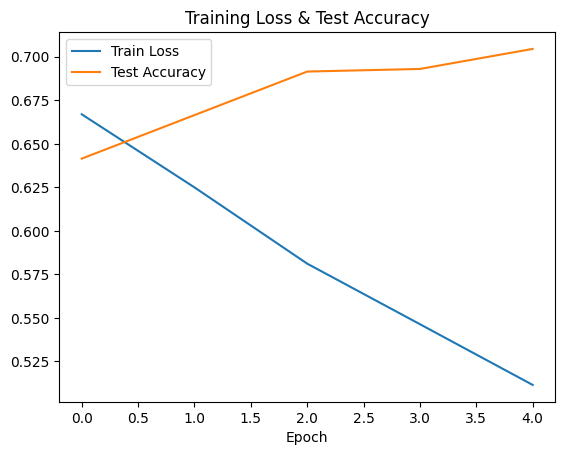

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Training Loss & Test Accuracy')
plt.xlabel('Epoch')
plt.show()
